# Heart Fail Analysis with ensemble modeling

**Gopal Joshi, Diploma**

1. Introduction
2. Install libraries
3. Load and check data<br>
    3.1 Load data<br>
    3.2 Outlier detection<br>
    3.3 Check for missing values<br>
4. Feature analysis<br>
	4.1 Numeric Values<br>
	4.2 Categorical Values<br>
5. Feature engineering<br>
	5.1 Create Categorical Values<br>
6. Simple Modeling<br>
	6.1 Data Splitting<br>
	6.2 Cross Validate Models<br>
	6.3 Hyperparamater tunning for selected models<br>
	6.4 Plot learning curves<br>
	6.4 Feature importance of the tree based classifiers<br>
7. Ensemble modeling<br>
	7.1 Combining models<br>
8. Prediction



# 1. Introduction

Heart failure is a chronic, progressive condition in which the heart muscle is unable to pump enough blood to meet the body's needs for blood and oxygen. Basically, the heart can't keep up with its workload. There are certain factors which increase chances of heart fail. It can be either mental or physical factors.

In this notebook, i will classification with feature engineering and ensemble modeling. First of all i will display some feature analysis and in that last i will do model evalution and preditions.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv


# 2. Install Libraries

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import Counter
import seaborn as sns

# Modeling
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

%matplotlib inline


# 3. Load and check data

# <font size="4">3.1 Load data</font>

In [3]:
# Load dataset using python pandas and display top 5 data

df = pd.read_csv('/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


We have person informations like Age, anaemia, creatinine, diabetes etc which are features and DEATH_EVENT is label

# <font size="4">3.2 Outlier detection</font>


In [4]:
def detect_outliers(df,n,features):
    outlier_indices = []
    """
    Detect outliers from given list of features. It returns a list of the indices
    according to the observations containing more than n outliers according
    to the Tukey method
    """
    # iterate over features(columns)
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from numeric features
outliers_to_drop = detect_outliers(df, 2 ,["age","anaemia","creatinine_phosphokinase","platelets", "serum_creatinine", "serum_sodium", "time"])

I used Tukey method. Tukey method is a single-step multiple comparison procedure and statistical test. It can be used to find means that are significantly different from each other. I detected outliers from the numerical values features (Age, anaemia, creatinine_phosphokinase etc). Then, i considered outliers as rows that have at least two outlied numerical values.


In [5]:
df.loc[outliers_to_drop] # Show the outliers rows

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT


Awesome, There is not features containing more than 2 outliers

# <font size="4">3.3 Check for missing values</font>

In [6]:
# Find columns with null values
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Dataset does not have any missing values

In [7]:
# Infos
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [8]:
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

# 4. Feature analysis

# <font size="4">4.1 Numeric Values</font>

<AxesSubplot:>

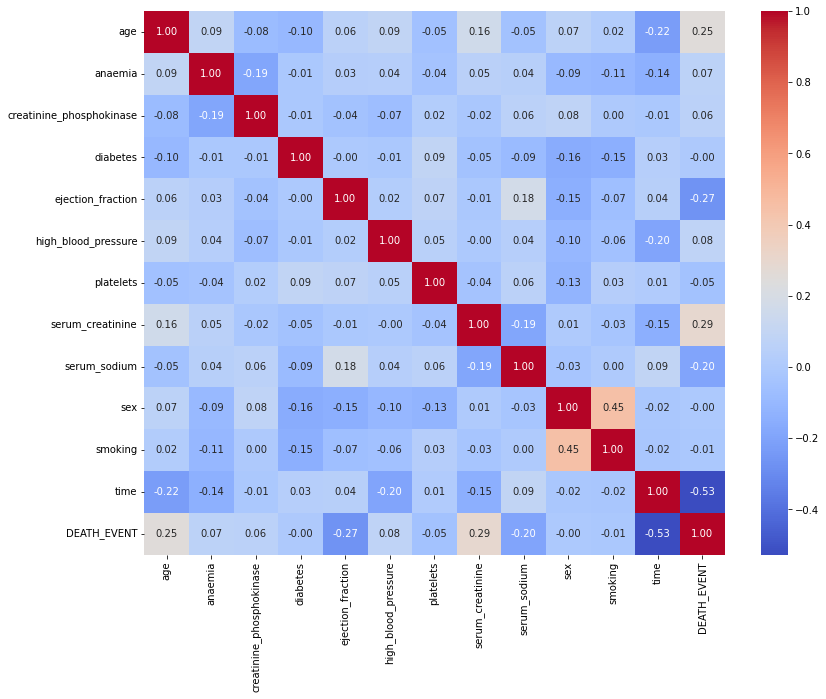

In [9]:
plt.figure(figsize=(13,10))
sns.heatmap(df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

age, serum_creatinine feature seems to have a significative correlation with the death event probability. ejection_fraction and serum_sodium also negatively corelated with death event

This does not mean that other features are not useful. We need to explore in detail these features to detarmine it corelation



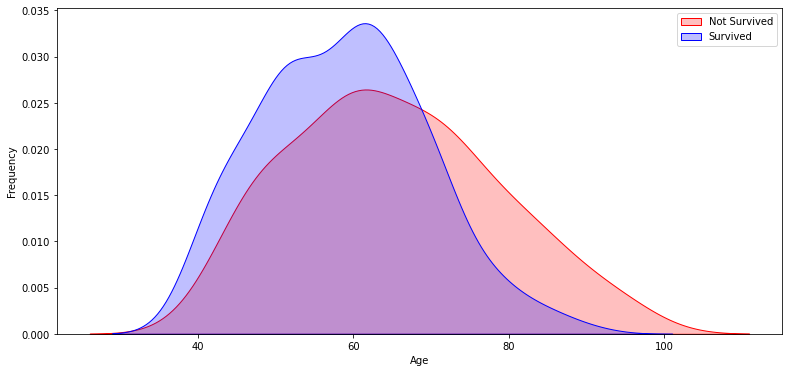

In [10]:
# Explore Age vs DEATH_EVENT
plt.figure(figsize=(13,6))
g = sns.kdeplot(df["age"][df["DEATH_EVENT"] == 1], color="Red", shade = True)
g = sns.kdeplot(df["age"][df["DEATH_EVENT"] == 0], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g.legend(["Not Survived","Survived"])


When we superimpose the two densities , we cleary see a peak correponsing (between 45 and 75) to babies and very young childrens.


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


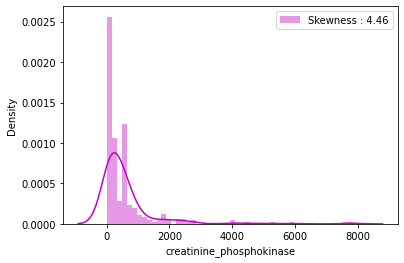

In [11]:
# Explore Fare distribution 
g = sns.distplot(df["creatinine_phosphokinase"], color="m", label="Skewness : %.2f"%(df["creatinine_phosphokinase"].skew()))
g = g.legend(loc="best")

As we can see, creatine phosphokinase distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled.

In this case, it is better to transform it with the log function to reduce this skew.

In [12]:
# Apply log to Fare to reduce skewness distribution
df["creatinine_phosphokinase"] = df["creatinine_phosphokinase"].map(lambda i: np.log(i) if i > 0 else 0)


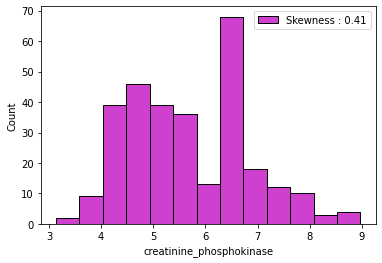

In [13]:
g = sns.histplot(df["creatinine_phosphokinase"], color="m", label="Skewness : %.2f"%(df["creatinine_phosphokinase"].skew()))
g = g.legend(loc="best")

Skewness is clearly reduced after the log transformation


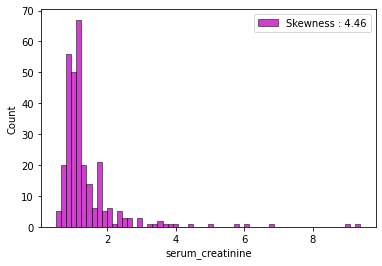

In [14]:
# Explore Fare distribution 
g = sns.histplot(df["serum_creatinine"], color="m", label="Skewness : %.2f"%(df["serum_creatinine"].skew()))
g = g.legend(loc="best")

Serum creatinine distribution is very skewed. In this case, it is better to transform it with the log function to reduce this skew.

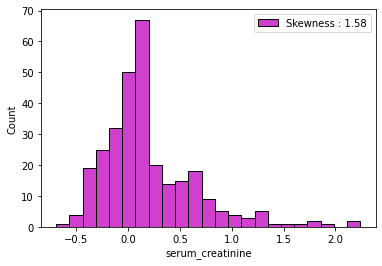

In [15]:
# Apply log to Fare to reduce skewness distribution
df["serum_creatinine"] = df["serum_creatinine"].map(lambda i: np.log(i) if i > 0 else 0)
g = sns.histplot(df["serum_creatinine"], color="m", label="Skewness : %.2f"%(df["serum_creatinine"].skew()))
g = g.legend(loc="best")

# <font size="4">4.2 Categorical Values</font>

**Anaemia**

Text(0, 0.5, 'Survival Probability')

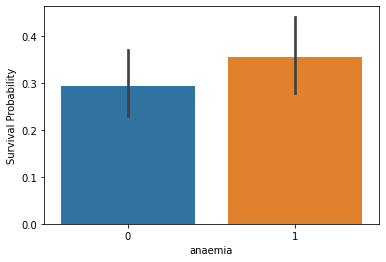

In [16]:
g = sns.barplot(x="anaemia",y="DEATH_EVENT",data=df)
g.set_ylabel("Survival Probability")

**Sex**

Text(0, 0.5, 'Survival Probability')

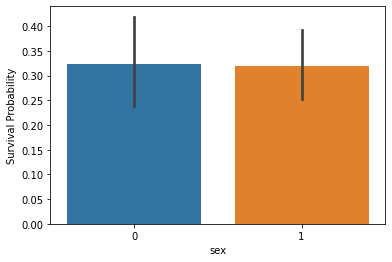

In [17]:
g = sns.barplot(x="sex",y="DEATH_EVENT",data=df)
g.set_ylabel("Survival Probability")

In [18]:
df[["sex","DEATH_EVENT"]].groupby('sex').mean()


,DEATH_EVENT
sex,
0,0.323810
1,0.319588


Gender of patient Male = 1, Female = 0

Accrding to observation male and female both have similar chances of survival. So Sex, might not play an important role in the prediction of the death.



**diabetes**

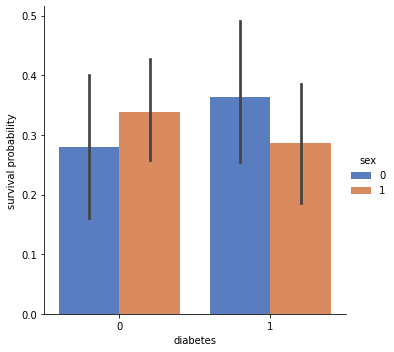

In [19]:
# Explore diabetes vs Survived by Sex
g = sns.catplot(x="diabetes", y="DEATH_EVENT", hue="sex", data=df,
                   kind="bar", palette="muted")
g.set_ylabels("survival probability")

Its clearly obvious that female with diabetes has more chances of heart fail

**High blood pressure**

Text(0, 0.5, 'Survival Probability')

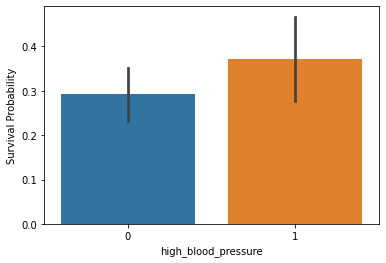

In [20]:
g = sns.barplot(x="high_blood_pressure",y="DEATH_EVENT",data=df)
g.set_ylabel("Survival Probability")

People with high blood preasure has more chances of heart fail. Lets 

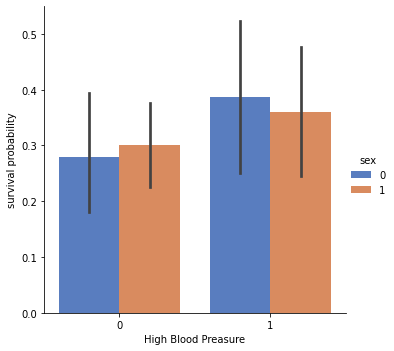

In [21]:
# Explore diabetes vs Survived by Sex
g = sns.catplot(x="high_blood_pressure", y="DEATH_EVENT", hue="sex", data=df,
                    kind="bar", palette="muted")
g.set_ylabels("survival probability")
g.set_xlabels("High Blood Preasure")

Female with high blood preasure has more thances of heart fails and if female does not have blood preasure then she has very less chances comparing to male

**Serum Sodium / Smoking**

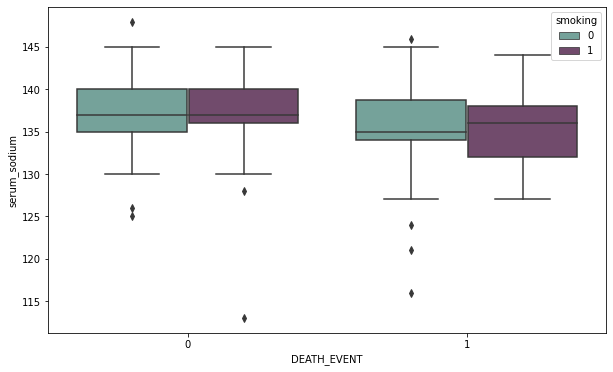

In [22]:
# Explore Serum Sodium vs Death Event vs Smoking

plt.figure(figsize=(10,6))
sns.boxplot(x=df["DEATH_EVENT"], y=df['serum_sodium'], hue=df['smoking'], palette=["#6daa9f","#774571"])
plt.show()

There is know correlation between smoking and Serum Sodium. Compared to non-smoker users, smokers had significantly increased levels of serum sodium. 

https://www.researchgate.net/publication/259625450_Effect_of_cigarette_smoking_on_blood_sodium_and_potassium_levels_in_sudanese_subjects


**Explore Platelets vs Anemia vs Death Event**

<AxesSubplot:xlabel='DEATH_EVENT', ylabel='platelets'>

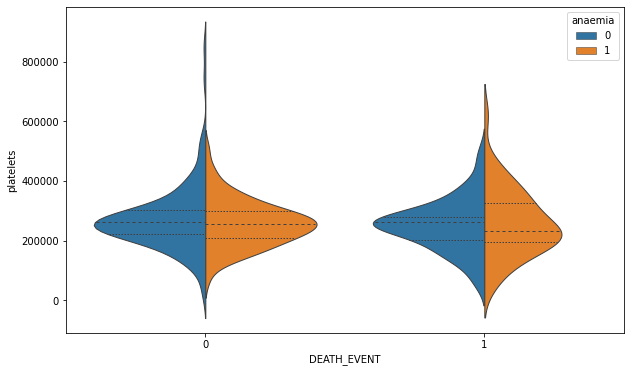

In [23]:
plt.figure(figsize=(10,6))
sns.violinplot(data=df, x="DEATH_EVENT", y="platelets", hue="anaemia",
               split=True, inner="quart", linewidth=1,
               )

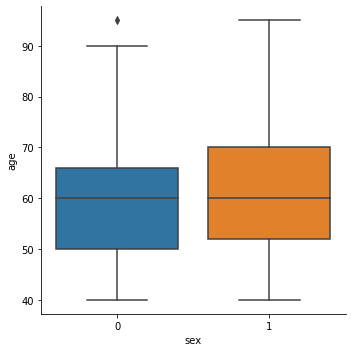

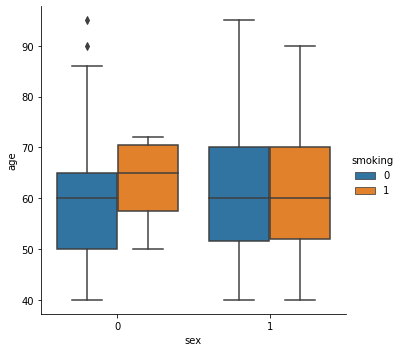

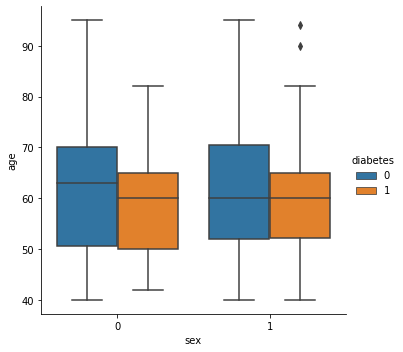

In [24]:
# Explore Age vs Sex, Parch , Pclass and SibSP
sns.catplot(y="age",x="sex",data=df,kind="box")
sns.catplot(y="age",x="sex",hue="smoking", data=df,kind="box")
sns.catplot(y="age",x="sex",hue="diabetes", data=df,kind="box")

# 5. Feature engineering

# <font size="4">5.1 Create Categorical Values</font>

In [25]:
df = pd.get_dummies(df, columns = ["anaemia"], prefix="ena")
df = pd.get_dummies(df, columns = ["diabetes"], prefix="dia")
df = pd.get_dummies(df, columns = ["high_blood_pressure"], prefix="hbp")
df = pd.get_dummies(df, columns = ["sex"], prefix="sex")
df = pd.get_dummies(df, columns = ["smoking"], prefix="smk")

In [26]:
df.time.value_counts()

250    7
187    7
10     6
186    6
107    6
      ..
97     1
96     1
86     1
77     1
285    1
Name: time, Length: 148, dtype: int64

# 6. Modeling

# <font size="4">6.1 Data Splitting</font>


In [27]:
## Separate train dataset and test dataset
features = df.drop(["DEATH_EVENT"], axis=1)
labels = df["DEATH_EVENT"]
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=7)

# <font size="4">6.2 Cross Validate Models</font>


I compared 7 most popular classification models and evaluate the mean accuracy by kfold cross validation procedure

* Logistic regression
* Decision Tree
* AdaBoost
* SVC
* Random Forest
* Gradient Boosting
* KNN



In [28]:
def evaluate_model(models):
    """
    Takes a list of models and returns chart of cross validation scores using mean accuracy
    """
    
    # Cross validate model with Kfold stratified cross val
    kfold = StratifiedKFold(n_splits = 10)
    
    result = []
    for model in models :
        result.append(cross_val_score(model, x_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

    cv_means = []
    cv_std = []
    for cv_result in result:
        cv_means.append(cv_result.mean())
        cv_std.append(cv_result.std())

    result_df = pd.DataFrame({
        "CrossValMeans":cv_means,
        "CrossValerrors": cv_std,
        "Models":[
            "LogisticRegression",
            "DecisionTreeClassifier",
            "AdaBoostClassifier",
            "SVC",
            "RandomForestClassifier",
            "GradientBoostingClassifier",
            "KNeighborsClassifier"
        ]
    })

    # Generate chart
    bar = sns.barplot(x = "CrossValMeans", y = "Models", data = result_df, orient = "h")
    bar.set_xlabel("Mean Accuracy")
    bar.set_title("Cross validation scores")
    return result_df

,CrossValMeans,CrossValerrors,Models
0,0.804286,0.095818,LogisticRegression
1,0.760238,0.046438,DecisionTreeClassifier
2,0.784524,0.044686,AdaBoostClassifier
3,0.660238,0.014602,SVC
4,0.799048,0.073086,RandomForestClassifier
5,0.798571,0.077899,GradientBoostingClassifier
6,0.660714,0.067185,KNeighborsClassifier


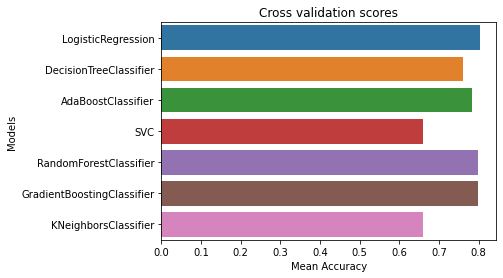

In [29]:
# Modeling step Test differents algorithms 
random_state = 30
models = [
    LogisticRegression(random_state = random_state),
    DecisionTreeClassifier(random_state = random_state),
    AdaBoostClassifier(DecisionTreeClassifier(random_state = random_state), random_state = random_state, learning_rate = 0.2),
    SVC(random_state = random_state),
    RandomForestClassifier(random_state = random_state),
    GradientBoostingClassifier(random_state = random_state),
    KNeighborsClassifier(),
]
evaluate_model(models)

On the base of validation scores, I decided to go with LogisticRegression, RandomForest, GradientBoosting , and DecisionTree classifiers for the ensemble modeling



# <font size="4">6.3 Hyperparameter tunning for selected models</font>


To be continued...

Please upvote and share my notebook if you find it useful - It keeps me motivated :)